### Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25") using ATTENTION MODEL

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Training on a dataset of 10000 human readable dates and their equivalent, standardized machine readable dates.  

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:01<00:00, 7877.51it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

- `dataset`: a list of tuples of (human readable date, machine readable date)
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index 
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

In [4]:
Tx = 30   # maximum length of human readable date
Ty = 10   # output length ( YYYY-MM-DD )
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character using `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character using `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


In [5]:
# example 
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


### ATTENTION MECHANISM
<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> Neural machine translation with attention</center></caption>

In [6]:
# shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [7]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    # use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a"
    s_prev = repeator(s_prev)
    # use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([a, s_prev])
    # use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e.
    e = densor1(concat)
    # use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies
    energies = densor2(e)
    # use "activator" on "energies" to compute the attention weights "alphas"
    alphas = activator(energies)
    # use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas, a])
    
    return context

In [8]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [9]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # the input of the model with a shape (Tx,)
    # s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # initialize empty list of outputs
    outputs = []
       
    # define your pre-attention Bi-LSTM. Remember to use return_sequences=True
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # iterate for Ty steps
    for t in range(Ty):
    
        # perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # apply the post-attention LSTM cell to the "context" vector.
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # append "out" to the "outputs" list
        outputs.append(out)
    
    # create model instance taking three inputs and returning the list of outputs
    model = Model([X, s0, c0], outputs)

    return model

In [10]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 30, 64)        17920       input_1[0][0]                    
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[0][0]            

In [11]:
opt = Adam(lr = 0.005, beta_1=0.9, beta_2=0.999, decay = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [19]:
model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100)

Epoch 1/20
10000/10000 [==============================] - 29s - loss: 3.7375 - dense_3_loss_1: 0.0582 - dense_3_loss_2: 0.0509 - dense_3_loss_3: 0.4733 - dense_3_loss_4: 0.7055 - dense_3_loss_5: 0.0066 - dense_3_loss_6: 0.0848 - dense_3_loss_7: 0.7790 - dense_3_loss_8: 0.0067 - dense_3_loss_9: 0.6237 - dense_3_loss_10: 0.9488 - dense_3_acc_1: 0.9814 - dense_3_acc_2: 0.9814 - dense_3_acc_3: 0.8074 - dense_3_acc_4: 0.8012 - dense_3_acc_5: 1.0000 - dense_3_acc_6: 0.9778 - dense_3_acc_7: 0.7628 - dense_3_acc_8: 1.0000 - dense_3_acc_9: 0.7635 - dense_3_acc_10: 0.6596    
Epoch 2/20
10000/10000 [==============================] - 28s - loss: 3.4893 - dense_3_loss_1: 0.0571 - dense_3_loss_2: 0.0510 - dense_3_loss_3: 0.4513 - dense_3_loss_4: 0.6405 - dense_3_loss_5: 0.0059 - dense_3_loss_6: 0.0826 - dense_3_loss_7: 0.7288 - dense_3_loss_8: 0.0067 - dense_3_loss_9: 0.5942 - dense_3_loss_10: 0.8712 - dense_3_acc_1: 0.9811 - dense_3_acc_2: 0.9815 - dense_3_acc_3: 0.8160 - dense_3_acc_4: 0.8235 - d

In [ ]:
# pretrained model
# model.load_weights('models/model.h5')    

In [21]:
def pp(example):
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

In [31]:
pp("1 March 2001")

source: 1 March 2001
output: 2000-03-01


Plotting attention values from the model

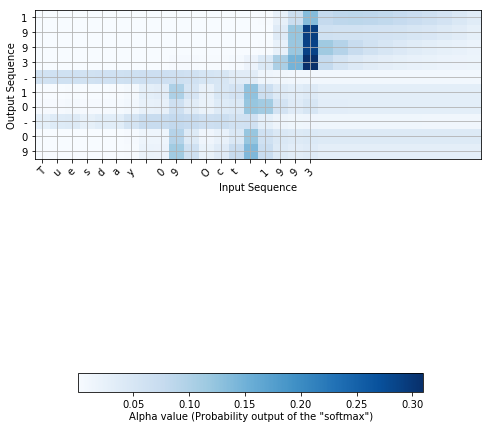

In [32]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)